In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import random
import math
%matplotlib inline

Using TensorFlow backend.


In [2]:
images_dir = "./images"    # location where image exists 

digits = list(map(str, range(10))) + ["ba", "pa"]  # image labels 
# map digits to their respective directory path
digits_dir = dict(zip(digits, map(lambda d: os.path.join(images_dir, d), digits)))

In [3]:
total_images = sum(len(glob.glob(os.path.join(folder, "*.jpg"))) for _, folder in digits_dir.items())
total_images

1681

In [4]:

im_width = im_height = 128
batch_size = 32
validation_split = 0.3

datagen = ImageDataGenerator(rescale=1.0/255.0, 
                             validation_split=validation_split,
                             shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=10, 
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
                            )

train_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="training")
validation_gen = datagen.flow_from_directory(images_dir, target_size=(im_height, im_width), batch_size=batch_size, subset="validation")
train_steps_per_epoch = int(total_images * (1 - validation_split)) // batch_size
validation_steps_per_epoch = int(total_images * validation_split) // batch_size

Found 1180 images belonging to 12 classes.
Found 501 images belonging to 12 classes.


In [5]:

from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Flatten
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_img = Input(shape=(im_height, im_width, 3))
_ = conv_block(input_img, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
_ = GlobalMaxPool2D()(_)
_ = Dense(units=128, activation="relu")(_)
_ = Dense(units=12, activation="softmax")(_)

model = Model(inputs=input_img, outputs=_)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 96)        55392     
_________________________________________________________________
batc

In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, epochs=2, 
                              validation_data=validation_gen, validation_steps=validation_steps_per_epoch)

In [ ]:
model.save("keras.h5")


print("Saved model to disk")

In [ ]:
model.save_weights("weight.h5")

In [ ]:
from keras.models import load_model
modell = load_model('model.h5')
modell.summary()

In [10]:
X, Y_true = next(validation_gen)
Y_true = Y_true.argmax(axis=-1)
Y_pred = model.predict_on_batch(X).argmax(axis=-1)


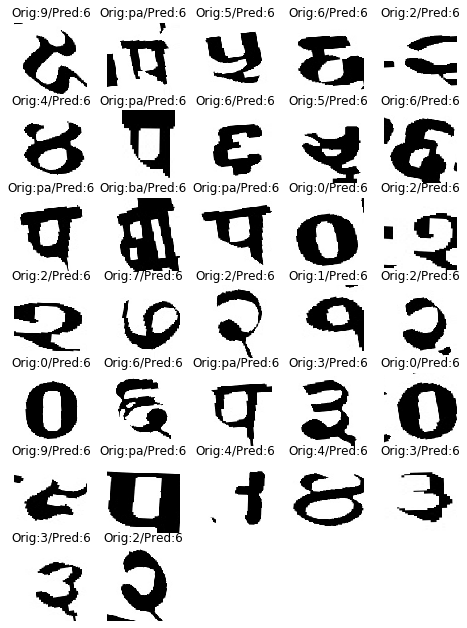

In [11]:
n_cols = 5
n_rows = math.ceil(len(X) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols+3, n_rows+4))
for i, (x, y_true, y_pred) in enumerate(zip(X, Y_true, Y_pred)):
    ax = axes.flat[i]
    ax.imshow(x, aspect='equal')
    ax.set_title("Orig:{}/Pred:{}".format(digits[y_true], digits[y_pred]))

for ax in axes.flat:
    ax.axis('off')

In [ ]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['acc'], label='Traininng accuracy')
    axes[0].plot(history.history['val_acc'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()


    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [7]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_num.h5")

In [8]:
# load json and create model
json_file = open('model_num.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_num.h5")
print("Loaded model from disk")

loaded_model.save('model_num.hdf5')
loaded_model=load_model('model_num.hdf5')

Loaded model from disk


/home/diwas/.conda/envs/tf/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
loaded_model.predict_classes("./images/1/1.jpg")

AttributeError: 'Model' object has no attribute 'predict_classes'